---
title: "6. Model fitting using MCMC"
---

# Model fitting using MCMC

Next, we'll try fitting our model to some simulated data.


## Imports

First, we import necessary packages.


In [4]:
import numpyro
numpyro.set_host_device_count(4)  # Necessary to make numpyro realise we have more than one CPU
import jax
# set jax to use cpu
jax.config.update('jax_platform_name', 'cpu')
import numpy as np
import jax.numpy as jnp
from numpyro import distributions as dist
from functools import partial
from behavioural_modelling.decision_rules import softmax
from behavioural_modelling.utils import choice_from_action_p
from typing import Tuple, Union
import matplotlib.pyplot as plt
# import colormaps as cmaps
import os, requests
# from matplotlib import font_manager, pyplot as plt

# # Some code to make figures look nicer
# url = 'https://github.com/google/fonts/blob/main/ofl/heebo/Heebo%5Bwght%5D.ttf?raw=true'
# r = requests.get(url)
# if r.status_code == 200:
#     with open('./Heebo.ttf', 'wb') as f: f.write(r.content)
# font_manager.fontManager.addfont('./Heebo.ttf')
# plt.rcParams.update({'lines.linewidth': 1, 'lines.solid_capstyle': 'butt', 'legend.fancybox': True, 'axes.facecolor': 'fafafa', 'savefig.edgecolor': 'fafafa', 'savefig.facecolor': 'fafafa', 'figure.subplot.left': 0.08, 'figure.subplot.right': 0.95, 'figure.subplot.bottom': 0.07, 'figure.facecolor': 'fafafa', 'figure.dpi': 80, 'lines.color': '383838', 'patch.edgecolor': '383838', 'text.color': '383838', 'axes.edgecolor': '383838', 'axes.labelcolor': '383838', 'xtick.color': '616161', 'ytick.color': '616161', 'font.family': 'Heebo', 'font.weight': 'regular', 'font.size': 12, 'axes.titlesize': 14, 'axes.labelsize': 12, 'xtick.labelsize': 10, 'ytick.labelsize': 10})


## Functions from the previous section

Here we'll (mostly) copy the functions we've implemented in the previous sections.

### ⚠️ One important change

We're going to update the basic `asymmetric_rescorla_wagner_update` function so that it is more compatible with `jax.lax.scan`, as we'll need to use this later.

Rather than taking separate `outcome` and `chosen` arguments, representing the reward received on the current trial and the action chosen on the current trial, we'll instead take a single `outcome_chosen` argument, which is a tuple of `(outcome, chosen)`. As mentioned in previous sections, this is a common pattern in JAX code, as it allows us to use `jax.lax.scan` more easily (since it only supports functions with a single input argument).

We'll also update its return values, so that it returns the `updated_value` and a tuple of `(prediction_error, value)`, rather than just `value`. This will make it easier to use with `jax.lax.scan` as well.

In [5]:
@jax.jit
def asymmetric_rescorla_wagner_update(
    value: jax.typing.ArrayLike,
    outcome_chosen: Tuple[jax.typing.ArrayLike, jax.typing.ArrayLike],
    alpha_p: float,
    alpha_n: float,
) -> Tuple[jax.typing.ArrayLike, jax.typing.ArrayLike]:
    """
    Updates the estimated value of a state or action using the Asymmetric Rescorla-Wagner learning rule.

    The function calculates the prediction error as the difference between the actual outcome and the current
    estimated value. It then updates the estimated value based on the prediction error and the learning rate,
    which is determined by whether the prediction error is positive or negative.

    Value estimates are only updated for chosen actions. For unchosen actions, the prediction error is set to 0.

    Args:
        value (float): The current estimated value of a state or action.
        outcome_chosen (Tuple[float, float]): A tuple containing the actual outcome and a binary value indicating
            whether the action was chosen.
        alpha_p (float): The learning rate used when the prediction error is positive.
        alpha_n (float): The learning rate used when the prediction error is negative.

    Returns:
        Tuple[float, float]: The updated value and the prediction error.
    """

    # Unpack the outcome and the chosen action
    outcome, chosen = outcome_chosen

    # Calculate the prediction error
    prediction_error = outcome - value

    # Set prediction error to 0 for unchosen actions
    prediction_error = prediction_error * chosen

    # Set the learning rate based on the sign of the prediction error
    alpha_t = (alpha_p * (prediction_error > 0)) + (alpha_n * (prediction_error < 0))

    # Update the value
    updated_value = value + alpha_t * prediction_error

    return updated_value, (value, prediction_error)

def asymmetric_rescorla_wagner_update_choice(
    value: jax.typing.ArrayLike,
    outcome_key: Tuple[jax.typing.ArrayLike, jax.random.PRNGKey],
    alpha_p: float,
    alpha_n: float,
    temperature: float,
    n_actions: int,
) -> np.ndarray:
    """
    Updates the value estimate using the asymmetric Rescorla-Wagner algorithm, and chooses an
    option based on the softmax function.

    Args:
        value (jax.typing.ArrayLike): The current value estimate.
        outcome_key (Tuple[jax.typing.ArrayLike, jax.random.PRNGKey]): A tuple containing the outcome and the PRNG key.
        alpha_p (float): The learning rate for positive outcomes.
        alpha_n (float): The learning rate for negative outcomes.
        temperature (float): The temperature parameter for softmax function.
        n_actions (int): The number of actions to choose from.

    Returns:
        Tuple[np.ndarray, Tuple[jax.typing.ArrayLike, np.ndarray, int, np.ndarray]]:
            - updated_value (jnp.ndarray): The updated value estimate.
            - output_tuple (Tuple[jax.typing.ArrayLike, np.ndarray, int, np.ndarray]):
                - value (jax.typing.ArrayLike): The original value estimate.
                - choice_p (jnp.ndarray): The choice probabilities.
                - choice (int): The chosen action.
                - choice_array (jnp.ndarray): The chosen action in one-hot format.
    """

    # Unpack outcome and key
    outcome, key = outcome_key

    # Get choice probabilities
    choice_p = softmax(value[None, :], temperature).squeeze()

    # Get choice
    choice = choice_from_action_p(key, choice_p)

    # Convert it to one-hot format
    choice_array = jnp.zeros(n_actions, dtype=jnp.int16)
    choice_array = choice_array.at[choice].set(1)

    # Get the outcome and update the value estimate
    updated_value, (value, prediction_error) = asymmetric_rescorla_wagner_update(
        value,
        (outcome, choice_array),
        alpha_p,
        alpha_n,
    )

    return updated_value, (value, choice_p, choice_array, prediction_error)

asymmetric_rescorla_wagner_update_choice = jax.jit(asymmetric_rescorla_wagner_update_choice, static_argnums=(5,))

def asymmetric_rescorla_wagner_update_choice_iterator(
    outcomes: jax.typing.ArrayLike,
    alpha_p: float,
    alpha_n: float,
    temperature: float,
    n_actions: int,
    key: jax.random.PRNGKey,
) -> Tuple[jnp.ndarray, jnp.ndarray, jnp.ndarray, jnp.ndarray]:
    """
    Updates the value estimates using the asymmetric Rescorla-Wagner algorithm and generates choices for each trial.

    Args:
        outcomes (jax.typing.ArrayLike): The outcomes for each trial.
        alpha_p (float): The learning rate for positive outcomes.
        alpha_n (float): The learning rate for negative outcomes.
        temperature (float): The temperature parameter for the softmax function.
        n_actions (int): The number of actions to choose from.
        key (jax.random.PRNGKey): The random key.

    Returns:
        Tuple[jnp.ndarray, jnp.ndarray, jnp.ndarray, jnp.ndarray]:
            - values (jnp.ndarray): The value estimates.
            - choice_ps (jnp.ndarray): The choice probabilities.
            - choices (jnp.ndarray): The chosen actions.
            - prediction_errors (jnp.ndarray): The prediction errors.
    """

    # Use partial to create a function with fixed parameters
    asymmetric_rescorla_wagner_update_choice_partial = partial(
        asymmetric_rescorla_wagner_update_choice,
        alpha_p=alpha_p,
        alpha_n=alpha_n,
        temperature=temperature,
        n_actions=n_actions,
    )

    # Generate random keys using JAX
    keys = jax.random.split(key, N_TRIALS)

    # Initialize the value estimates
    value = jnp.ones(5) * 0.5

    # Loop using scan
    _, (values, choice_ps, choices, prediction_errors) = jax.lax.scan(
        asymmetric_rescorla_wagner_update_choice_partial,
        value,
        (outcomes, keys),
    )

    return values, choice_ps, choices, prediction_errors

# JIT
asymmetric_rescorla_wagner_update_choice_iterator = jax.jit(asymmetric_rescorla_wagner_update_choice_iterator, static_argnums=(4,))

asymmetric_rescorla_wagner_update_choice_iterator_vmap = jax.vmap(
    asymmetric_rescorla_wagner_update_choice_iterator,
    in_axes=(None, 0, 0, 0, None, None),
)

## Simulate some data

We'll start by simulating some data from the model we've defined. We'll generate some parameter values for each of our simulated "subjects", and then generate some simulated choices for each subject.

We're going to generate parameter values using appropriate distributions. The `alpha_p` and `alpha_n` parameters will be drawn from a Beta distribution since their values lie between 0 and 1, while the `temperature` parameter will be drawn from an exponential distribution. This is because the `temperature` parameter is always positive, and the exponential distribution is a good choice for positive-valued parameters.

> **NOTE**: We don't need any of the other variables returned by the model here, so we'll just ignore them.

In [48]:
# Number of subjects
N_SUBJECTS = 40

# Generate parameter values for each subject
rng = np.random.default_rng(0)
alpha_p = rng.beta(5, 5, size=N_SUBJECTS)
alpha_n = rng.beta(5, 5, size=N_SUBJECTS)
temperature = rng.beta(5, 5, size=N_SUBJECTS)

# Number of trials
N_TRIALS = 200

# Reward probabilities for each of our 5 actions
reward_probs = jnp.array([0.2, 0.4, 0.8, 0.1, 0.5])

# Generate rewards for each trial for each action using Numpy
# There's no need to use JAX for this
rng = np.random.default_rng(0)
rewards = rng.binomial(n=1, p=reward_probs, size=(N_TRIALS, len(reward_probs)))

# Run the model for each subject
_, _, choices, _ = asymmetric_rescorla_wagner_update_choice_iterator_vmap(
    rewards,
    alpha_p,
    alpha_n,
    temperature,
    5,
    jax.random.PRNGKey(0),
)

## Set up another function for model fitting

Our current implementation simulates **choices** for each trial based on the current expected value. However, when we're fitting the model we won't want to do this. This is because we want to fit the model to the actual choices made by the subject, rather than the choices that the model would make (you could do this, but it generally works poorly) - we're essentially saying "_given_ this option was chosen on the previous trial, how close is the model's prediction for the next choice to the actual choice made?".

This means we want our model to return the expected value for each option on each trial, given the observed choice, rather than generating a choice and updating based on that choice.

For this reason, we'll use our original `asymmetric_rescorla_wagner_update` function and do the same as before to make it run across all trials for all subjects. As mentioned above, we've modified this function slightly to make it more compatible with `jax.lax.scan`.

We can ignore the softmax function here as we don't need to generate choices for each trial sequentially, and this can be applied to our estimated values at the end.

In [49]:
@jax.jit
def asymmetric_rescorla_wagner_update_iterator(
    outcomes: jax.typing.ArrayLike,
    choices: jax.typing.ArrayLike,
    alpha_p: float,
    alpha_n: float,
) -> Tuple[jnp.ndarray, jnp.ndarray, jnp.ndarray, jnp.ndarray]:
    """
    Updates the value estimates using the asymmetric Rescorla-Wagner algorithm.

    Args:
        outcomes (jax.typing.ArrayLike): The outcomes for each trial.
        alpha_p (float): The learning rate for positive outcomes.
        alpha_n (float): The learning rate for negative outcomes.

    Returns:
        Tuple[jnp.ndarray, jnp.ndarray]:
            - values (jnp.ndarray): The value estimates.
            - prediction_errors (jnp.ndarray): The prediction errors.
    """

    # Use partial to create a function with fixed parameters
    asymmetric_rescorla_wagner_update_partial = partial(
        asymmetric_rescorla_wagner_update,
        alpha_p=alpha_p,
        alpha_n=alpha_n,
    )

    # Initialize the value estimates
    value = jnp.ones(5) * 0.5

    # Loop using scan
    _, (values, prediction_errors) = jax.lax.scan(
        asymmetric_rescorla_wagner_update_partial,
        value,
        (outcomes, choices),
    )

    return values, prediction_errors

asymmetric_rescorla_wagner_update_iterator_vmap = jax.vmap(
    asymmetric_rescorla_wagner_update_iterator,
    in_axes=(None, 0, 0, 0),
)

In contrast to the functions above which randomly make choices on each trial, we're passing in `choices` as an argument, which is a `(n_trials, n_actions)` array of choices made on each trial.

Our `vmap` function will then apply this function to each subject, and we can use this to calculate the log likelihood of the data given the model parameters. As before, the rewards are the same for every subject, so we set the corresponding value for `in_axes` to `None`. The remaining arguments are the choices and parameters, which differ for every subject - for this reason, we set the corresponding value for `in_axes` to `0`.

As with our other `vmap`-ed functions, we can then use this to simulate expected values for each trial for each subject. We don't need the prediction errors here, so we'll only assign the expected values to a variable (assigning the prediction errors to `_`).

In [50]:
# Run the model for each subject
values, _ = asymmetric_rescorla_wagner_update_iterator_vmap(
    rewards,
    choices,
    alpha_p,
    alpha_n,
)

### Applying the softmax function

As mentioned above, we don't need to apply the softmax function to generate choices, but we will need to apply it to our expected values to calculate the _probability_ of the observed choices given the data. We can do this by applying the softmax function to the expected values for each subject once they have been calculated, as we don't need them to be calculated for each trial sequentially.

The `softmax` function is designed to calculate choice probabilities for a single subject, we we'll again use `vmap` to map it over subjects.

In [51]:
choice_p = jax.vmap(softmax, in_axes=(0, 0))(values, temperature)

## Set up the statistical model

As described [in this guide](/docs/computational_modelling/guide/3.-mcmc-sampling/#creating-a-numpyro-model), the model we've implemented so far is our **behavioural model** - it generates simulated behaviour based on a set of parameters. We want to estimate parameter values for this model for each subject in our dataset - to do this we need to set up a **statistical model**, which describes how we think the parameters are distributed across subjects.

We will do this using [NumPyro](https://num.pyro.ai/), which is a probabilistic programming library built on top of JAX. This will allow us to use MCMC to estimate the parameters of our model.

### Building a hierarchical model for our parameters

We will use a hiearchical modelling approach using a non-centred parameterisation (as described [in this guide](/docs/computational_modelling/guide/4.-hierarchical-models/)) to estimate the parameters of our model. This assumes that each subject is drawn from a group rather than being completely independent, and uses the information from the group to improve the estimates of the individual subjects.

We have **three parameters** that we want to estimate:
* `alpha_p` - the learning rate for positive prediction errors. This parameter takes values between 0 and 1.
* `alpha_n` - the learning rate for negative prediction errors. This parameter takes values between 0 and 1.
* `temperature` - the temperature parameter for the softmax function. This parameter takes values between 0 and infinity.

It is often easiest to estimate parameters whose values lie within clear ranges, whereas the softmax temperature parameter can take any positive value. To make this easier to estimate, we can sample within the range 0-1 and then transform it to the range 0-infinity using the reciprocal function:

$$
\text{temperature} = \frac{1}{\text{temperature}}
$$

### Create a function for generating non-centred parameterisations

We need to set up each parameter using a non-centred parameterisation, which means that each parameter is composed of three separate components:
* A group-level parameter mean `mu` which is drawn from a normal distribution with mean 0 and standard deviation 1, with one value for all subjects.
* A group-level parameter standard deviation `sigma`, which is drawn from a half-normal distribution with a scale parameter of 1, with one value for all subjects.
* A subject-level parameter `offset` which is drawn from a normal distribution with mean 0 and standard deviation 1, with one value for each subject.

The subject-level parameter is then calculated as:
```python
subject_parameter = mu + sigma * offset
```

Creating these componenets for every parameter can be quite repetitive, so we'll create a function to do this for us.

In [52]:
import numpyro

def create_subject_params(
    name: str, n_subs: int
) -> Union[dist.Normal, dist.HalfNormal, dist.Normal]:
    """
    Creates group mean, group sd and subject-level offset parameters.
    Args:
        name (str): Name of the parameter
        n_subs (int): Number of subjects
    Returns:
        Union[dist.Normal, dist.HalfNormal, dist.Normal]: Group mean, group sd, and subject-level offset parameters
    """

    # Group-level mean and SD
    group_mean = numpyro.sample("{0}_group_mean".format(name), dist.Normal(0, 1))
    group_sd = numpyro.sample("{0}_group_sd".format(name), dist.HalfNormal(1))

    # Subject-level offset
    offset = numpyro.sample(
        "{0}_subject_offset".format(name), dist.Normal(0, 1), sample_shape=(n_subs,)  # One value per subject
    )

    # Calculate subject-level parameter
    subject_param = numpyro.deterministic("{0}_subject_param".format(name), group_mean + offset * group_sd)

    return subject_param


This function generates the three components of the non-centred parameterisation for a single parameter, given the name of the parameter and the number of subjects. It then uses these to form the subject-level parameter value for each subject.

We use `numpyro.deterministic` to create a deterministic variable in the model, which is a variable that is not sampled from, but is instead calculated from other variables in the model. This is useful for creating variables that are derived from other variables in the model, but that we don't want to sample from directly. We could instead do something like:

```python
return group_mean + offset * group_std
```

But this would mean that the subject-level parameter wouldn't actually be stored, and this is the parameter whose value we actually care about.

We could also adjust the priors on these parameters, but these values should all work reasonably well for our purposes.

### Bounding our parameters

As it stands, this approach will generate parameters that are unbounded, which is not ideal for our purposes as all of our parameters will be estimated in the range 0-1. One way to do this is to use a transforamtion that brings the parameters into the range 0-1. This is a common approach in Bayesian modelling, as it allows us to estimate parameters in an unbounded space, but then transform them to a bounded space.

We can add this to the function using the `jax.scipy.special.expit` function, which is the inverse of the logit function. This function transforms any value to the range 0-1, which is perfect for our purposes.

In [53]:
def create_subject_params(
    name: str, n_subs: int
) -> Union[dist.Normal, dist.HalfNormal, dist.Normal]:
    """
    Creates group mean, group sd and subject-level offset parameters.
    Args:
        name (str): Name of the parameter
        n_subs (int): Number of subjects
    Returns:
        jnp.array: Subject-level parameter for each subject
    """

    # Group-level mean and SD
    group_mean = numpyro.sample("{0}_group_mean".format(name), dist.Normal(0, 0.5))
    group_sd = numpyro.sample("{0}_group_sd".format(name), dist.HalfNormal(0.5))

    # Subject-level offset
    offset = numpyro.sample(
        "{0}_subject_offset".format(name),
        dist.Normal(0, 0.5),
        sample_shape=(n_subs,),  # One value per subject
    )

    # Calculate subject-level parameter
    subject_param = numpyro.deterministic(
        "{0}_subject_param".format(name),
        jax.scipy.special.expit(group_mean + offset * group_sd),
    )

    return subject_param

The subject-level parameter is now calculated as:

```python
jax.scipy.special.expit(group_mean + offset * group_sd)
```

As a quick demonstration of how this works, we can generate some random values and transform them. We can see that the transformed values are all between 0 and 1.

(array([ 6.,  5.,  7., 14., 19., 28., 43., 46., 32., 46., 50., 55., 51.,
        57., 52., 45., 49., 43., 53., 44., 36., 50., 27., 36., 39., 22.,
        20., 13.,  9.,  3.]),
 array([0.01985156, 0.05103884, 0.08222611, 0.11341339, 0.14460067,
        0.17578794, 0.20697522, 0.2381625 , 0.26934978, 0.30053705,
        0.33172435, 0.36291161, 0.39409891, 0.42528617, 0.45647344,
        0.48766074, 0.518848  , 0.5500353 , 0.58122259, 0.61240983,
        0.64359713, 0.67478442, 0.70597166, 0.73715895, 0.76834625,
        0.79953349, 0.83072078, 0.86190808, 0.89309537, 0.92428261,
        0.95546991]),
 <BarContainer object of 30 artists>)

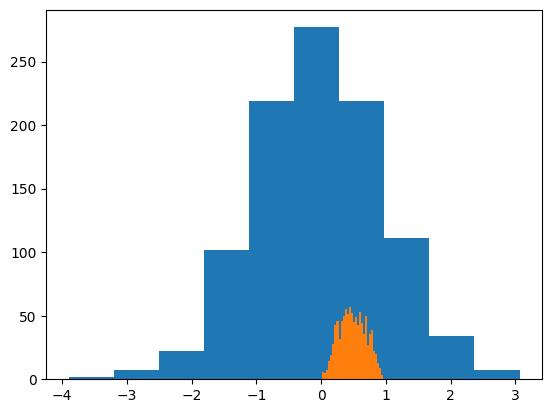

In [54]:
# Sample from a normal distribution
rng = np.random.default_rng(0)
x = rng.normal(0, 1, size=1000)

# Plot the histogram of the untransformed data
plt.hist(x)

# Plot the histogram of the transformed data
plt.hist(jax.scipy.special.expit(x), bins=30)

### Putting the model together

We can now write a function that encapsulates the statistical model for our parameters:

In [55]:
def asymmetric_rescorla_wagner_statistical_model(
    outcomes: jnp.ndarray,
    choices: jnp.ndarray,
) -> None:
    """
    Asymmetric Rescorla-Wagner model for NumPyro.

    This forms a hierarchical model using non-centred parameterisation.

    Args:
        outcomes (jnp.ndarray): The outcomes for each trial.
        choices (jnp.ndarray): The choices for each trial.

    Returns:
        None: The function does not return anything; it only samples from the model.
    """

    # Get number of subjects based on choices
    n_subs = choices.shape[0]

    # Create subject-level parameters
    alpha_p = create_subject_params("alpha_p", n_subs)
    alpha_n = create_subject_params("alpha_n", n_subs)
    temperature = create_subject_params("temperature", n_subs)


    # Run the model for each subject
    values, _ = asymmetric_rescorla_wagner_update_iterator_vmap(
        rewards,
        choices,
        alpha_p,
        alpha_n,
    )

    # Get choice probabilities using inverse temperature
    choice_p = jax.vmap(softmax, in_axes=(0, 0))(values, temperature)

    # Bernoulli likelihood
    numpyro.sample(
        "observed_choices",
        dist.Bernoulli(probs=choice_p),
        obs=choices,
    )

Let's break this down a bit:

#### 1. We enter the outcomes and observed choices

```python
def asymmetric_rescorla_wagner_statistical_model(
    outcomes: jnp.ndarray,
    choices: jnp.ndarray,
) -> None:
```

We provide the observed outcomes, which are used by our model to calculate prediction errors and update expected value estimates. We also provide the observed choices, which are the choices made by the subject on each trial that we use to calculate the likelihood of the data given the model.

#### 2. We set up priors for our parameters 

```python
alpha_p = create_subject_params("alpha_p", n_subs)
alpha_n = create_subject_params("alpha_n", n_subs)
temperature = create_subject_params("temperature", n_subs)
```

The priors on our parameters are generated using the function we defined above to create non-centred parameterisations for each parameter. All of these are estimated in the range 0-1.

#### 3. We calculate the expected values for each subject

Next, we feed these parameters, along with the subjects' choices, into our **behavioural model** to estimate expected values for each subject. We use the `vmap`-ed version of our model to apply it to each subject.

```python
values, _ = asymmetric_rescorla_wagner_update_iterator_vmap(
    rewards,
    choices,
    alpha_p,
    alpha_n,
)
```

#### 4. We apply the softmax function to the expected values

```python
choice_p = jax.vmap(softmax, in_axes=(0, 0))(values, 1 / temperature)
```

We then apply the softmax function to the expected values for each subject, using the temperature parameter for each subject. This gives us the probability of each action being chosen on each trial. We take the reciprocal of the temperature parameter to transform it back to the range 0-infinity.

#### 5. We calculate the likelihood of the data given the model

```python
numpyro.sample(
    "observed_choices",
    dist.Bernoulli(probs=choice_p),
    obs=choices,
)
```

Finally, we calculate the likelihood of the observed choices given the model. We use a Bernoulli distribution to model the likelihood of the observed choices, with the probability of each choice being given by the softmax function applied to the expected values. The Bernoulli distribution is a good choice for binary data, as it models the probability of a single binary outcome.

## Sampling

Now that we have our model set up, we can sample from it using MCMC. We'll use the `NUTS` sampler, which is a good general-purpose sampler that works well for many models.

There are few important settings for the sampler that it's worth being aware of:
* `num_warmup` - the number of warmup steps to take. This is the number of steps the sampler takes to "warm up" before it starts sampling. During warmup, the sampler adapts its step size and other parameters to try to find a good region of the parameter space to sample from.
* `num_samples` - the number of samples to take after warmup. This is the number of samples that the sampler will take after warmup to estimate the posterior distribution.
* `num_chains` - the number of chains to run. Running multiple chains can help to diagnose problems with the sampler, as you can compare the results from different chains to see if they agree.  

Here, we'll set the number of warmups and samples to a lower number for the sake of speed, but in practice you would want to run more warmup and samples to get a better estimate of the posterior distribution.

In [62]:
from numpyro.infer import MCMC, NUTS

# Sampling settings
N_SAMPLES = 4000  # This should be higher in practice
N_WARMUP = 2000  # This should be higher in practice
N_CHAINS = 4

# Set up the NUTS sampler for our model
nuts_kernel = NUTS(asymmetric_rescorla_wagner_statistical_model)

# Set up the MCMC object
mcmc = MCMC(
    nuts_kernel, num_samples=N_SAMPLES, num_warmup=N_WARMUP, num_chains=N_CHAINS
)

# Set the random key for sampling
rng_key = jax.random.PRNGKey(0)

# Run the sampler
mcmc.run(rng_key, rewards, choices)

# Get the samples
samples = mcmc.get_samples()

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

## Diagnostics

It's worth checking that the sampling procedure has gone as it should do. There are various ways to do this, many of which are implemented in [Arviz](https://python.arviz.org/en/latest/api/diagnostics.html), and we won't cover them in detail here. One quick check we can run is to look at the traceplot of the samples, which shows the value of each parameter over the course of the sampling procedure. This can give us a sense of whether the sampler has converged to the posterior distribution.

In [63]:
# TO BE IMPLEMENTED

## Parameter recovery

We can also check how well our model **recovers** true parameter values. Because we have fit it to simulated data here, we can compare the estimated parameter values to the true parameter values we used to generate the data. This can give us a sense of how well our model is able to recover the true parameters.

Some useful functions for doing this are included in our [`model_fit_tools`](https://github.com/tobywise/model-fit-tools) package. For example, we can easily plot the estimated parameter values against the true parameter values to see how well they match up using the `plot_recovery` function.

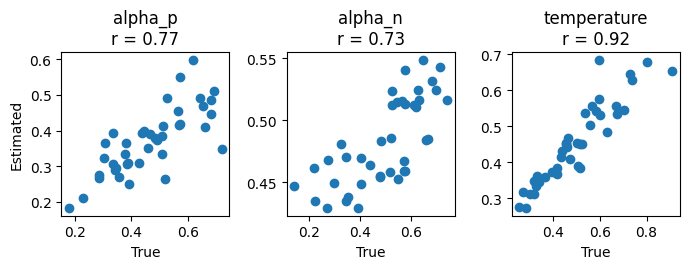

In [74]:
from model_fit_tools.plotting import plot_recovery

# Plot the recovery of thhe parameters
plot_recovery(
    np.stack([alpha_p, alpha_n, temperature]).T,
    np.dstack([samples['alpha_p_subject_param'], samples['alpha_n_subject_param'], samples['temperature_subject_param']]),
    ["alpha_p", "alpha_n", "temperature"],
)

As you can see, the values are correlated but they're not perfect (in particular, the range of values for `alpha_` is quite constrained). This is likely due to the fact that the "task" here is not really designed to be a good test of the model.